In [35]:
%env CUDA_VISIBLE_DEVICES=0,3
%env TMPDIR=/raid/users/ryan_cheng/tmp
import os
import glob
import re
import json
import random
import time
import pickle
from absl import app, flags
from tqdm import tqdm
from datetime import datetime
import openai
from openai import OpenAI
from transformers import AutoTokenizer
import pandas as pd
import numpy as np

np.random.seed(0)

try:
    from vllm import LLM, SamplingParams
    import ray
except ImportError:
    pass
with open(os.path.abspath('../ryan_openai.txt'), 'r') as f:
    # ../.. for notebook, .. for script
    client = OpenAI(api_key=f.read().rstrip('\n'))

vllm_alias = {
    'mistral': 'mistralai/Mistral-7B-v0.3',
    'mixtral': 'mistralai/Mixtral-8x7B-v0.1',
    'mistral-instruct': 'mistralai/Mistral-7B-Instruct-v0.3',
    'mixtral-instruct': 'mistralai/Mixtral-8x7B-Instruct-v0.1',

    'gemma': 'google/gemma-7b',
    'gemma-2-27b': 'google/gemma-2-27b',
    'gemma-2-27b-it': 'google/gemma-2-27b-it', # instruction tuned

    'Llama-3-70B': 'meta-llama/Meta-Llama-3-70B',
    'Llama-3-8B': 'meta-llama/Meta-Llama-3-8B',
    'Llama-3.1-405B': 'meta-llama/Meta-Llama-3.1-405B',
    'Llama-3.1-8B': 'meta-llama/Meta-Llama-3.1-8B',
    'Llama-3.1-70B': 'meta-llama/Meta-Llama-3.1-70B', 
    'Llama-3.1-405B-Instruct': 'meta-llama/Meta-Llama-3.1-405B-Instruct',
    'Llama-3.1-70B-Instruct': 'meta-llama/Meta-Llama-3.1-70B-Instruct',
    'Llama-3.1-8B-Instruct': 'meta-llama/Meta-Llama-3.1-8B-Instruct'
}

# run 'ray start --head --num-gpus <NUM>' in bash first!
def setup_vllm():
    if config['gpus'] > 1:
        ray.init(ignore_reinit_error=True) 

    global llm
    global tokenizer

    if config['model'] in vllm_alias:
        tokenizer = AutoTokenizer.from_pretrained(vllm_alias[config['model']])
    else:
        print('Attempting to use tokenizer for', config['model'])
        try:
            tokenizer = AutoTokenizer.from_pretrained(config['model'])
        except:
            print('Info: passing tokenizer setup')

    if config['vllm']:
        if config['model'] in vllm_alias:
            if config['fp8']:
                llm = LLM(model=vllm_alias[config['model']], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'], gpu_memory_utilization=0.75)
            elif vllm_alias[config['model']] == 'meta-llama/Meta-Llama-3.1-70B' or vllm_alias[config['model']] == 'meta-llama/Meta-Llama-3.1-70B-Instruct':
                llm = LLM(model=vllm_alias[config['model']], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'], gpu_memory_utilization=0.9, max_model_len=12880)
            else:
                llm = LLM(model=vllm_alias[config['model']], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'])
        else:
            try:
                llm = LLM(model=config['model'], tensor_parallel_size=config['gpus'], download_dir=config['model_dir'])
            except:
                print('Info: Passing vllm setup')
    else:
        llm = AutoModelForCausalLM.from_pretrained(
            config['model'],
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            device_map="auto"
        )

def completion_create_helper(model_name, config, prompt, llm=None):
    # limit prompt in all cases
    if model_name not in vllm_models:
        # for some reason vLLM models simply repeat this last statement if present
        prompt += " Limit your answer to three sentences or less!"

    ret = '' # return the output ret at the end and use to calculate cost

    if model_name == "gpt-3.5-turbo-instruct":
        ret = client.completions.create(
                model="gpt-3.5-turbo-instruct",
                prompt=prompt,
                temperature=0.8,
                max_tokens=config['max_tokens'],
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
        )
        ret = ret.choices[0].text.strip()
        #find_line = ret.find("\n")
        #if find_line != -1:
            #ret = ret[:find_line]
    elif model_name in ["gpt-3.5-turbo", "gpt-3.5-turbo-16k", "gpt-4-turbo", "gpt-4o", "gpt-4o-mini"]:
        ret = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "system", "content": prompt}],
            max_tokens=config['max_tokens']
        )
        ret = ret.choices[-1].message.content

    elif model_name in vllm_models and llm:
        sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=config['max_tokens'])
        messages = [
            {"role": "user", "content": prompt}
        ]
        if tokenizer.chat_template:
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        output = llm.generate([prompt], sampling_params)
        ret = output[0].outputs[0].text

    else: # specify model path of finetuned model in model directory
        inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
        with torch.no_grad():
            output_ids = llm.generate(**inputs, max_length=8192)
        output_ids = output_ids[:, inputs.input_ids.shape[1]:]
        ret = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # if config['model'] not in vllm_models:
    #     running_cost_for_iteration += api_cost(prompt=prompt, answer=ret, model=config['model'])
    #     if config['verbose']:
    #         print(f"RUNNING COST FOR ITERATION SO FAR: {running_cost_for_iteration}")
    
    return ret

def completion_create(model_name, config, prompt, llm=None, keep_trying=False):
    try:
        return completion_create_helper(model_name, config, prompt, llm)
    except (openai.APIError, openai.OpenAIError) as e:
        # print("ERROR", e)
        # print("sleeping for 10 seconds.")
        time.sleep(10)
        if keep_trying:
            return completion_create(model_name, config, prompt, llm, keep_trying)
        else:
            return None
            
def write_json(write_path, json_dict):
    if not os.path.exists(write_path):
        with open(write_path, 'w') as f:
            json.dump([], f)
    with open(write_path, 'r') as f:
        evaluations = json.load(f)
    evaluations.append(json_dict)
    with open(write_path, 'w') as f:
        json.dump(evaluations, f, indent=4)

env: CUDA_VISIBLE_DEVICES=0
env: TMPDIR=/raid/users/ryan_cheng/tmp


In [20]:
config_gpt4_mini = {
    'agent1_model': 'gpt-4o-mini',
    'agent2_model': 'gpt-4o-mini',
    'eval_model': 'gpt-4o-mini',
    'agent1_role': "\nPerson 1: ",
    'agent2_role': "\nPerson 2: ",
    #'generic_prompt': generic, 
    #'agent1_specific': agent_1_specific + do_not_repeat_text, 
    #'agent2_specific': agent_2_specific + do_not_repeat_text,
    #'eval_prompts': eval_prompts,
    'iterations': 1, # not used
    'verbose': True, # not used
    'write': True,
    'convo_length_limit': 10,
    'max_tokens': 256,
    'gpus': 2,
    'task_name': 'Persona Chat',
}

In [56]:
np.random.seed(0)
random_indices = np.array([np.random.choice(len(persona_chat), size=2, replace=False) for _ in range(10)])
random_indices # pairs of indices of Persona to  use in conversation

array([[7710, 4426],
       [5525, 2032],
       [ 574, 6234],
       [2303,  263],
       [3890,  877],
       [8913, 6509],
       [7400, 2988],
       [6578, 4878],
       [5014, 8746],
       [8254, 5155]])

In [22]:
def generate_conversation(p1, p2, config, pturn=1, write=False, write_path='data/persona/persona_chat.json'):
    conv_dict = {
        "task_name": config['task_name'],
        "P1": p1,
        "P2": p2,
        "conversation": [],
        "pturn": pturn # beginning person (1 or 2)
        }
    round_num = 0
    while round_num < config['convo_length_limit']:
        if pturn == 1:
            prompt = "You are P1, and you are having a conversation with P2. Your backstory is:\n" + p1 + "\n" + "So far, the conversation is as below, and it is your turn to speak next.\n" + ("".join(conv_dict["conversation"]) if len(conv_dict["conversation"]) != 0 else "[You are starting the conversation.]") + "P1: "
            pturn = 2
            conv_dict["conversation"].append("P1: " + completion_create(config['agent1_model'], config, prompt) + "\n")
        else:
            prompt = "You are P2, and you are having a conversation with P1. Your backstory is:\n\n" + p2 + "\n\n" + "So far, the conversation is as below, and it is your turn to speak next.\n" + ("".join(conv_dict["conversation"]) if len(conv_dict["conversation"]) != 0 else "[You are starting the conversation.]") + "P2: "
            pturn = 1     
            conv_dict["conversation"].append("P2: " + completion_create(config['agent2_model'], config, prompt) + "\n")
        round_num += 1

    conv_dict["rounds"] = round_num
    if write:
        write_json(write_path, conv_dict)
    return conv_dict


# Persona Chat Generation

In [23]:
persona_chat = pd.read_csv('./data/persona/personality.csv')
print("Length:", len(persona_chat))
persona_chat.head()

Length: 8939


,Unnamed: 0,Persona,chat
0,0,i like to remodel homes. i like to go hunting...,"hi , how are you doing ? i am getting ready to..."
1,1,my mom is my best friend. i have four sisters...,"hi , how are you doing today ?\ni am spending ..."
2,2,i had a gig at local theater last night. i wo...,"we all live in a yellow submarine , a yellow s..."
3,3,i am very athletic. i wear contacts. i have b...,hi ! i work as a gourmet cook .\ni do not like...
4,4,i am primarily a meat eater. i am a guitar pl...,how are you doing today\nwhat do you do for ca...


In [ ]:
# Generate conversations using personas from persona chat (unneeded)
conversations = []
for p1i, p2i in tqdm(random_indices):
    conversations.append(generate_conversation(persona_chat.iloc[p1i]["Persona"], persona_chat.iloc[p2i]["Persona"], config_gpt4_mini, write=True))

100%|██████████| 10/10 [01:44<00:00, 10.50s/it]


# Synthetic Persona Chat

In [4]:
syn_persona_chat = pd.read_csv('./data/synthetic-persona/New-Persona-New-Conversations.csv')
syn_persona_chat.head()

,user 1 personas,user 2 personas,Best Generated Conversation
0,I'm moving to a new city to pursue my culinary...,"I am comfortable with the weather, and enjoy s...","User 1: Hi! How are you?\nUser 2: Good, thanks..."
1,I used my artistic skills to teach children ho...,I like to run and do yoga in my spare time.\nM...,User 1: Hey how are you doing?\nUser 2: Doing ...
2,"I enjoy spending time with my pets, and I love...",I am close to my mother and love to spend time...,"User 1: Hello there, how are you doing today?\..."
3,"My cupcake business keeps me busy, but I also ...",I collect memories and seashells from my trave...,User 1: hi there!\nUser 2: Hey! How's your day...
4,The weather is perfect for cheering!\ni listen...,I had to move across country for my job.\nI go...,User 1: How is your day going?\nUser 2: Great!...


In [21]:
syn_persona_chat.iloc[0]["Best Generated Conversation"]

"User 1: Hi! How are you?\nUser 2: Good, thanks for asking! How about yourself?\nUser 1: I'm doing pretty well.  I'm excited to be moving to a new city soon!\nUser 2: Oh that's awesome! What city are you moving to?\nUser 1: I'm moving to Portland, Oregon.  I'm going to be pursuing my culinary dreams there.\nUser 2: That sounds amazing! I love Portland.  I'm originally from there.\nUser 1: Really? That's so cool!  Do you still live there?\nUser 2: No, I moved away a few years ago.  But I still visit my family there often.\nUser 1: That's great.  Do you have any favorite places to visit in Portland?\nUser 2: Yes, I love going to Powell's Books.  It's the largest independent bookstore in the world.\nUser 1: That sounds amazing!  I've never been to Powell's Books before.  I'm definitely going to have to check it out.\nUser 2: You definitely should!  It's a really cool place.\nUser 1: Thanks for the recommendation!  I'm sure I'll love it.\nUser 2: No problem!  I'm glad I could help.\n"

In [ ]:
# Use generated conversations
conversations = []
for p1i, p2i in tqdm(random_indices):
    conversations.append(generate_conversation(syn_persona_chat.iloc[p1i]["user 1 personas"], syn_persona_chat.iloc[p2i]["user 2 personas"], config_gpt4_mini, write=True, write_path='data/persona/syn_persona_chat.json'))

100%|██████████| 10/10 [01:49<00:00, 10.91s/it]


In [11]:
def syn_conversation_to_list(conversation: str) -> list[str]:
    pattern = r"(User 1:|User 2:)(.*?)(?=(User 1:|User 2:|$))"
    matches = re.findall(pattern, conversation, re.DOTALL)

    # Combine consecutive entries with the same speaker
    combined_entries = []
    for speaker, message, _ in matches:
        if combined_entries and combined_entries[-1].startswith(speaker):
            combined_entries[-1] += " " + message.strip()
        else:
            combined_entries.append(f"{speaker.strip()} {message.strip()}")

    return combined_entries

In [12]:
syn_conversation_to_list(syn_persona_chat.iloc[0]["Best Generated Conversation"])

['User 1: Hi! How are you?',
 'User 2: Good, thanks for asking! How about yourself?',
 "User 1: I'm doing pretty well.  I'm excited to be moving to a new city soon!",
 "User 2: Oh that's awesome! What city are you moving to?",
 "User 1: I'm moving to Portland, Oregon.  I'm going to be pursuing my culinary dreams there.",
 "User 2: That sounds amazing! I love Portland.  I'm originally from there.",
 "User 1: Really? That's so cool!  Do you still live there?",
 'User 2: No, I moved away a few years ago.  But I still visit my family there often.',
 "User 1: That's great.  Do you have any favorite places to visit in Portland?",
 "User 2: Yes, I love going to Powell's Books.  It's the largest independent bookstore in the world.",
 "User 1: That sounds amazing!  I've never been to Powell's Books before.  I'm definitely going to have to check it out.",
 "User 2: You definitely should!  It's a really cool place.",
 "User 1: Thanks for the recommendation!  I'm sure I'll love it.",
 "User 2: No 

In [23]:
# Use conversations from dataset instead, taking the index of the conversation to be the first of the pair of random indices
orig_conversations = []
for p1i, p2i in tqdm(random_indices):
    conv = syn_persona_chat.iloc[p1i]
    conv_dict = {
        "task_name": 'Synthetic Persona Chat',
        "P1": conv['user 1 personas'],
        "P2": conv['user 2 personas'],
        "conversation": syn_conversation_to_list(conv["Best Generated Conversation"]),
        "pturn": 1 # beginning person (this dataset always starts with User 1)
        }
    orig_conversations.append(conv_dict)
    

100%|██████████| 10/10 [00:00<00:00, 12554.04it/s]


In [ ]:
for conversation in orig_conversations:
    eval_prompt_consistency(conversation, config_gpt4_mini)
    eval_all_line_consistency(conversation, config_gpt4_mini)
    eval_prev_line_consistency(conversation, config_gpt4_mini)

with open('data/persona/syn_persona_chat.json', 'w') as f:
        json.dump(orig_conversations, f, indent=4)

In [36]:
with open('data/persona/syn_persona_chat.json', 'w') as f:
        json.dump(orig_conversations, f, indent=4)

# Anthology of Backstories

## Download Anthology

In [24]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [32]:
import gdown

url = "https://drive.google.com/file/d/18ctlWJXfckgAsb0yC-vSi5sTlid4xFQk/view"
output_path = "./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip"
gdown.download(url, output_path, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=18ctlWJXfckgAsb0yC-vSi5sTlid4xFQk
From (redirected): https://drive.google.com/uc?id=18ctlWJXfckgAsb0yC-vSi5sTlid4xFQk&confirm=t&uuid=b9628dad-50ae-4340-99e0-812f195bbe31
To: /nfs/kun2/users/ryan_cheng/consistency_LLMs/data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip
100%|██████████| 173M/173M [00:01<00:00, 138MB/s]  


'./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip'

In [33]:
!unzip ./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip -d ./data/anthology/
!rm ./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip

Archive:  ./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl.zip
  inflating: ./data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl  


## Load Anthology Profiles

In [37]:
file_path = "data/anthology/Meta-Llama-3-70B_demographics_survey+political_affiliation_batch_1+2+3_no_word_cutoff.pkl"

try:
    with open(file_path, "rb") as f:
        df = pd.read_pickle(file_path)
except (EOFError, pickle.UnpicklingError) as e:
    print("Error loading pickle file:", e)

In [38]:
print(df.keys())

Index(['age_category_4_count_noncompliant',
       'age_category_4_is_llm_parsing_result',
       'age_category_4_is_survey_result',
       'age_category_4_llm_parsing_parsed_choice',
       'age_category_4_llm_parsing_prompt',
       'age_category_4_llm_parsing_question',
       'age_category_4_llm_parsing_response',
       'age_category_4_response_distribution', 'age_category_4_response_texts',
       'age_category_4_survey_choices', 'age_category_4_survey_prompt',
       'age_category_4_survey_question', 'education_level_count_noncompliant',
       'education_level_is_llm_parsing_result',
       'education_level_is_survey_result',
       'education_level_llm_parsing_parsed_choice',
       'education_level_llm_parsing_prompt',
       'education_level_llm_parsing_question',
       'education_level_llm_parsing_response',
       'education_level_response_distribution',
       'education_level_response_texts', 'education_level_survey_choices',
       'education_level_survey_prompt', 'edu

In [39]:
def count_sentences(paragraph):
    # Split sentences using punctuation (., !, ?) as well as commas
    sentences = re.split(r'[.!?]', paragraph)  # Split by sentence-ending punctuation
    return len(sentences)

In [42]:
personas = []

# The target phrase
target_phrase_start = "Answer:"
target_phrase_end = "Question:"

for text in df["age_category_4_llm_parsing_prompt"]:
    # Find the start index of the target phrase and extract text after it
    start_index = text.find(target_phrase_start) 
    stop_index = text.find(target_phrase_end, start_index) 
    persona = text[start_index+len(target_phrase_start)+1:stop_index]
    count = count_sentences(persona)
    if count > 20:
        personas.append({"persona": persona, "len": count})

len(personas)

4895

In [52]:
print(personas[0]['persona'])

I am in my late 30s, grew up in a small town in the mountains of southern Appalachia, left home at 18, was in the army, and worked for some time in the auto industry before starting my current job. What matters to me are my wife and children, faith, family, freedom, and the sanctity of life.

I didn’t have any exposure to science growing up. I grew up with the Bible and the world of make-believe. The first thing I remember being excited about was “The Little Engine That Could” which was about having a can-do attitude. Then I became interested in dinosaurs and started reading a lot about them. I read books by Sir David Attenborough and Carl Sagan. Then I got into Star Trek. That’s what I’m still most excited about. I have no idea why I’m not excited about sci-fi movies, and maybe I’m missing out on something, but I just don’t have the same enthusiasm for movies that I do for the science I read in books.

I’m interested in biology because it is so fundamental to all other sciences. I don

## Generate Details about Personas

Only has to be run once, if ./data/anthology/personas_updated.json is missing or if new persona backgrounds are to be sampled and extended

In [82]:
np.random.seed(0)
random_indices_anthology = np.random.choice(len(personas), size=200, replace=False).astype(int)
random_indices_anthology # random indices to generate profiles for

array([4029, 1755, 3834, 2078, 4129, 3819, 3722, 1974,  495, 3147, 3803,
       3837,  965, 1011,  142, 3371, 2955, 3127, 2744, 4813, 4158, 3699,
        311, 2814, 4128, 1393, 4841, 3566,  716,  891, 1877, 1934,   49,
        599,  556, 1428, 1979, 2443, 3568, 2574, 3756,  298,  861, 3011,
        651, 4509, 3073,  202, 3710,  148, 3170, 1489, 4761, 3460, 1272,
       4044,  898, 4548, 1687,  154,  158, 1800, 1515, 4475, 3071, 4073,
         39, 3615,  624, 1936, 2399, 4828, 3712, 2165, 2601, 4070, 2661,
       4371, 4555, 2884,  348, 4146, 1691,  873,  402, 4607, 3420,  130,
       4574, 4339, 2396, 3133, 3309,  541, 2724,  308, 2779,  933, 3582,
        562, 2519,  500, 3389, 1108,  534, 1692, 4481, 4883, 2471, 3608,
       1675, 1738, 4343, 4716, 3060, 3786,  113,  489,   98, 2290,  636,
       3570, 3328,  499, 4837, 2527, 3900,   42, 1437, 1051, 3975, 3320,
       1172, 4052, 4266, 4430, 2682, 2381, 1450, 4376, 3065,  394, 1900,
        125, 1997, 4061, 1794, 1419, 2509, 1326, 34

In [62]:
persona_prompt = "Provide a biography that includes all of the following attributes. It should not be presented as a list, but as if someone was providing the information naturally in an introduction in the first person. It should be contained to one paragraph. Here is a biography that you can add details to contain all of the attributes below.\n"

attributes_prompt = """Here are the attributions that must be in the biography:
- Name
- Age
- Where they're from
- Where their parents are from
- Religion and extent it is adhered to
- Socioeconomic status - current
- Socioeconomic status - childhood
- Siblings (including name, age, relationship)
- Languages and dialects spoken
- Sexual orientation
- Gender identity
- Relationship status
- Significant past relationships
- Occupation (current and past)
- Education
- Cultural influences
- Political views
- Health and wellness
- Hobbies and interests
- Values and beliefs outside religion
- Fears and anxieties
- Life goals and ambitions
- Defining life experiences
- Friendship circles
- Daily routine and habits
- Pet ownership (current and past)
- Favorite media
- Living situation
- Places traveled to"""


In [83]:
personas_updated = []
personas_small = np.array(personas)[random_indices_anthology]
for persona in tqdm(personas_small):
    agent_prompt = str(persona_prompt) + "Biography:" + str(persona) + "\n" + str(attributes_prompt)
    agent_prompt+= "\nUpdated Biography:"
    agent_answer = completion_create(
            config_gpt4_mini["agent1_model"],
            config_gpt4_mini,
            agent_prompt, 
            config_gpt4_mini["agent1_model"])
    personas_updated.append(agent_answer)


100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


In [90]:
with open('data/anthology/personas_updated.json', 'w') as f:
        json.dump([{"persona": personas_updated[i], "index": int(random_indices_anthology[i])} for i in range(len(personas_updated))], f, indent=4)

## Load Detailed Anthology Personas and Generate Conversations

In [ ]:
with open('data/anthology/personas_updated.json', 'r') as f:
        personas_updated = json.load(f)

In [99]:
np.array(personas_updated).reshape(-1, 2)[0]

array([{'persona': 'My name is Joon, I’m 22 years old, and I was born in South Korea but immigrated to the US at the age of four. Growing up in a Korean household, I learned the values of hard work and family from my grandparents, who faced significant hardships in their lives, leading to my current belief that no one deserves to be poor and that conversation is vital for progress. Now a college graduate from the University of Washington studying law and business, I’m passionate about social justice and engage with diverse opinions to challenge hypocrisy within society, all while navigating my identities as a bisexual, non-binary individual in a rapidly changing world.', 'index': 4029},
       {'persona': 'Hello, I’m Dr. Kenji Takahashi, a 60-year-old Asian American male from San Francisco, where my parents, both physicians from Japan, instilled in me the importance of community service and free-thinking. Growing up as an only child in a liberal household, I was immersed in both Englis

In [103]:
# Generate conversations using personas from anthology
conversations = []
config_gpt4_mini["task_name"] = "Anthology"
for p_dict1, p_dict2 in tqdm(np.array(personas_updated).reshape(-1, 2)):
    conversations.append(generate_conversation(p_dict1["persona"], p_dict2["persona"], config_gpt4_mini, write=True, write_path='data/anthology/persona_chat.json'))

100%|██████████| 100/100 [17:13<00:00, 10.34s/it]


## Summary prompt/answers

In [59]:
print(personas_updated[0])

My name is James, and I’m in my late 30s, hailing from a small town in the mountains of southern Appalachia, where my parents, originally from the deep South, instilled strong values in me, centered around faith and family. I grew up in a modest household, the oldest of three siblings, with my sister Sarah, who is 34, and my brother Mike, who is 28; our upbringing was rich in stories and imagination, largely influenced by the Bible, but it wasn't until I discovered my passion for biology and the wonders of the universe through the words of great thinkers like Sir David Attenborough that I truly began to understand the world around me. Currently, I work in the tech industry after a diverse career path that included time in the army and the auto industry, while my wife and our two children remain my top priorities, and together we navigate our daily life filled with curiosity, exploration, and values that stress the importance of freedom and the sanctity of life.


In [45]:
summary_prompt = """
    From the following biography, generate one sentence summaries for each of the attributes with similar structure to the accompanying examples:
        name = ""  # "My name is Jane Doe."
        age = ""  # "I am 35 years old."
        location_from = ""  # "I am from Houston, Texas."
        location_mother_from = "" # "My mother is from Capetown, South Africa."
        location_father_from = "" # "My father is from Mumbai, India."
        religion = "" # "I am Christian.", "I was raised Jewish but don't practice."
        socioeconomic_status = "" # I am middle class.", "I am a wealthy homeowner.", "I am struggling to make ends meet."
        siblings = "" # "I am an only child." "I have a brother and a sister."
        languages_spoken = "" # "I speak only English.", "I speak Portuguese, English, and Bengali."
        sexual_orientation = "" # "I am heterosexual.", "I'm bisexual."
        gender_identity = "" # "I am a woman.", "I identify as nonbinary."
        relationship_status = "" # "I'm currently single.", "I have been married for 4 years."
        significant_past_relationships = "" # "I was engaged for 2 years but it was called off.", "I have never been in a long term relationship."
        occupation_current = "" # "I am a landscaper.", "I do small business consulting."
        occupation_past = "" # "I used to be a frycook in high school.", "In college I worked as a librarian's assistant."
        education = "" # "I have my G.E.D.", "I have a bachelors in Finance from Northeastern University."
        cultural_influences = "" # "I grew up in a devout Mormon community.", "I grew up in a Nigerian Igbo community."
        political_views = "" # "I don't follow politics.", "I am a democratic socialist."
        health = "" # "I am very healthy and exercise often, but have a bad knee.", "I am legally blind."
        hobbies_and_interests = "" # "I enjoy painting and hiking.", "I am a huge history buff."
        beliefs_and_values = "" # "I believe minimizing our carbon footprint is imperative.", "I am vegan for moral reasons."
        fears_and_anxieties = "" # "I am deathly afraid of heights.", "I have anxiety with personal conflict."
        life_goals_and_ambitions = "" # "I hope to retire at an early age.", "I want to start my own company.", "All I want out of life is a big family."
        defining_life_experiences = "" # "I was orphaned at a young age.", "I would bake with my grandma every Sunday growing up."
        friendship_circles = "" # "I've had the same few best friends for years.", "I have no close friends but run in a lot of social circles."
        daily_routine_and_habits = "" # "I do a morning yoga routine every morning before work.", "I spend an hour reading every night before I go to bed."
        pet_ownership = "" # "I don't have any pets.", "I have a black laborador retriever named Sparky."
        favorite_media = "" # "I have rewatched the TV show Friends a dozen times.", "I watch football games every night."
        living_situation = "" # "I currently live by myself in a studio apartment.", "I live in a single-family home with my husband and two children."
        places_traveled = "" # "I have never left my home city.", "I have traveled to most of South America, and a few countries in Europe."

    """


In [54]:
summary_prompt += "\nBiography:" + personas_updated[0] + "\nFormat the output as above, with the attribute from the class matching the key for the attribute:\n name: <summary>\nage: <summary\n..."

summary_answer = completion_create(
        config_gpt4_mini["agent1_model"],
        config_gpt4_mini,
        summary_prompt,
        config_gpt4_mini["agent1_model"])


In [55]:
print(summary_answer)

name = "My name is James."  
age = "I am in my late 30s."  
location_from = "I am from a small town in the mountains of southern Appalachia."  
location_mother_from = "My mother is originally from the deep South."  
location_father_from = "My father is also originally from the deep South."  
religion = "I was raised with strong values centered around faith."  
socioeconomic_status = "I grew up in a modest household."  
siblings = "I have a sister named Sarah, who is 34, and a brother named Mike, who is 28."  
languages_spoken = "I speak English."  
sexual_orientation = ""  # Not specified  
gender_identity = ""  # Not specified  
relationship_status = "I am married."  
significant_past_relationships = ""  # Not specified  
occupation_current = "I work in the tech industry."  
occupation_past = "I have had a diverse career path that included time in the army and the auto industry."  
education = ""  # Not specified  
cultural_influences = "My upbringing was rich in stories and imaginati

# Consistency Evaluation

In [104]:
# (1) Takes in dialog, takes in base prompt, checks inconsistencies with base prompt for each line and output

def eval_prompt_consistency(conv_dict, config):
    #assert 'eval_prompt_consistency' not in conv_dict # warn if we are replacing metrics we don't mean to overwrite
    conv_dict['eval_prompt_consistency'] = []
    conv_dict['P1_prompt_consistency_score'] = 0
    conv_dict['P2_prompt_consistency_score'] = 0
    p1_utterances = 0
    p2_utterances = 0
    pturn = conv_dict["pturn"]
    for line in conv_dict["conversation"]:
        if pturn == 1:
            prompt = "For the following line spoken by P1, answer YES if the line contradicts the given backstory of P1, and answer NO if the line does not contradict the provided backstory of P1. P1's backstory is:\n" + conv_dict["P1"] + "\n P1 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts the given backstory of P1, and answer NO if the line does not contradict the provided backstory of P1, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_prompt_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P1_prompt_consistency_score'] += 1
            p1_utterances += 1
            pturn = 2
        else:
            prompt = "For the following line spoken by P2, answer YES if the line contradicts the given backstory of P2, and answer NO if the line does not contradict the provided backstory of P2. P2's backstory is:\n" + conv_dict["P2"] + "\n P2 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts the given backstory of P2, and answer NO if the line does not contradict the provided backstory of P2, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_prompt_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P2_prompt_consistency_score'] += 1
            p2_utterances += 1
            pturn = 1

    conv_dict['P1_prompt_consistency_score'] /= p1_utterances
    conv_dict['P2_prompt_consistency_score'] /= p2_utterances

In [105]:
# (2) Takes in dialog, checks inconsistencies with every line henceforth 

def eval_all_line_consistency(conv_dict, config):
    conv_dict['eval_all_line_consistency'] = []
    conv_dict['P1_all_line_consistency_score'] = 0
    conv_dict['P2_all_line_consistency_score'] = 0
    p1_utterances = 0
    p2_utterances = 0
    pturn = conv_dict["pturn"]
    for i, line in enumerate(conv_dict["conversation"]):
        if pturn == 1:
            # old prompt (checks backstory as well)
            #prompt = "For the following line spoken by P1, answer YES if the line contradicts any line stated by P1 or P1's provided background, and answer NO if the line does not contradict any line in the provided conversation history of P1 and P1's provided background. P1 has the following backstory:\n" + conv_dict["P1"] + "\nP1 had the following conversation with P2:\n" + "".join(conv_dict["conversation"]) + "\n P1 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts any line stated by P1 throughout the course of the conversation or P1's provided background, and answer NO if the line does not contradict any line in the provided conversation history of P1 and P1's provided background, followed by 1 sentence of reasoning.\n\n"
            prompt = "For the following line spoken by P1, answer YES if the line contradicts any line stated by P1, and answer NO if the line does not contradict any line in the provided conversation history of P1. \nP1 had the following conversation with P2:\n" + "".join(conv_dict["conversation"]) + "\n P1 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts any line stated by P1 throughout the course of the conversation, and answer NO if the line does not contradict any line in the provided conversation history of P1, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_all_line_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P1_all_line_consistency_score'] += 1
            p1_utterances += 1
            pturn = 2
        else:
            #prompt = "For the following line spoken by P2, answer YES if the line contradicts any line stated by P2 or P2's provided background, and answer NO if the line does not contradict any line in the provided conversation history of P2 and P2's provided background. P2 has the following backstory:\n" + conv_dict["P2"] + "\nP2 had the following conversation with P1:\n" + "".join(conv_dict["conversation"]) + "\n P2 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts any line stated by P2 throughout the course of the conversation or P2's provided background, and answer NO if the line does not contradict any line in the provided conversation history of P2 and P2's provided background, followed by 1 sentence of reasoning.\n\n"
            prompt = "For the following line spoken by P2, answer YES if the line contradicts any line stated by P2, and answer NO if the line does not contradict any line in the provided conversation history of P2. \nP2 had the following conversation with P1:\n" + "".join(conv_dict["conversation"]) + "\n P2 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts any line stated by P2 throughout the course of the conversation, and answer NO if the line does not contradict any line in the provided conversation history of P2, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_all_line_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P2_all_line_consistency_score'] += 1
            p2_utterances += 1
            pturn = 1

    conv_dict['P1_all_line_consistency_score'] /= p1_utterances
    conv_dict['P2_all_line_consistency_score'] /= p2_utterances

In [147]:
# (3) Survey of agent at every line (ANTHOLOGY ONLY FOR NOW)

def get_backstory_test(backstory, num_questions, config):
    ret = [[], []] # a list of questions, a list of answers
    for i in range(num_questions):
        qa = completion_create(config['eval_model'], config, "Based on the following backstory, generate a new fact-based multiple choice question with 5 choices addressed directly IN SECOND PERSON, along with its correct answer. Preface the question with 'Question:' and the answer with 'Answer:'." + '\n' + backstory + ("" if len(ret[0]) == 0 else "\nFor reference, all of the following questions have already been asked:\n" + ''.join(ret[0])))
        q = qa[qa.find('Question:'): qa.find('Answer:')]
        a = qa[qa.find('Answer:'): ]
        ret[0].append(q)
        ret[1].append(a)
    return ret

def score_backstory_test(prompt, backstory_test, config):
    total_score = 0
    answers = []
    verdicts = []
    for i in range(len(backstory_test[0])):
        answer = completion_create(config['eval_model'], config, prompt + "\n Based on your conversation above so far, answer the following multiple choice question.\n" + backstory_test[0][i])
        verdict = completion_create(config['eval_model'], config, "As part of grading a test, determine whether the given answer " + answer + " matches the following correct answer. Respond with either YES or NO.\n" + "Correct " + backstory_test[1][i])
        answers.append(answer)
        verdicts.append(verdict)
        score = 1 if 'yes' in verdict.lower() else 0
        # if score == 0:
            #print("WRONG!")
            #print("The prompt is\n" + prompt)
            # print("The correct answer to the question\n" + backstory_test[0][i] + "\nwas\n" + backstory_test[1][i] + "\nBut they answered\n" + answer)
        total_score += score
    return total_score, answers, verdicts

def eval_survey_consistency(conv_dict, config):
    p1_backstory = conv_dict["P1"]
    p2_backstory = conv_dict["P2"]
    p1_backstory_test = get_backstory_test(p1_backstory, 5, config)
    p2_backstory_test = get_backstory_test(p2_backstory, 5, config)
    
    conv_dict['eval_survey_consistency'] = []
    conv_dict['P1_survey_consistency_score'] = 0
    conv_dict['P2_survey_consistency_score'] = 0
    conv_dict['P1_backstory_test'] = p1_backstory_test
    conv_dict['P2_backstory_test'] = p2_backstory_test
    
    conversation = ""
    p1_utterances = 0
    p2_utterances = 0
    pturn = conv_dict["pturn"]
    for i, line in enumerate(conv_dict["conversation"]):
        conversation += line
        if pturn == 1:
            prompt = "You are P1, and you are having a conversation with P2. Your backstory is:\n" + p1_backstory + "\n" + "So far, the conversation is as below:\n" + conversation

            score, answers, verdicts = score_backstory_test(prompt, p1_backstory_test, config)
            conv_dict['eval_survey_consistency'].append([line, score, answers, verdicts])
            conv_dict['P1_survey_consistency_score'] += score

            p1_utterances += 1
            pturn = 2
        else:
            prompt = "You are P2, and you are having a conversation with P1. Your backstory is:\n" + p2_backstory + "\n" + "So far, the conversation is as below:\n" + conversation

            score, answers, verdicts = score_backstory_test(prompt, p2_backstory_test, config)
            conv_dict['eval_survey_consistency'].append([line, score, answers, verdicts])
            conv_dict['P2_survey_consistency_score'] += score
            p2_utterances += 1
            pturn = 1
    conv_dict['P1_survey_consistency_score'] /= p1_utterances
    conv_dict['P2_survey_consistency_score'] /= p2_utterances
    

In [106]:
# (4) Takes in dialog, checks for inconsistency with previous line 

def eval_prev_line_consistency(conv_dict, config):
    conv_dict['eval_prev_line_consistency'] = []
    conv_dict['P1_prev_line_consistency_score'] = 0
    conv_dict['P2_prev_line_consistency_score'] = 0
    p1_utterances = 0
    p2_utterances = 0
    pturn = conv_dict["pturn"]
    for i, line in enumerate(conv_dict["conversation"]):
        if pturn == 1:
            
            #prompt = "For the following line spoken by P1, answer YES if the line contradicts a previous line stated by P1 or P1's provided background, and answer NO if the line does not contradict the provided conversation history of P1 and P1's provided background. P1 has the following backstory:\n" + conv_dict["P1"] + "\nP1 had the following conversation with P2:\n" + "".join(conv_dict["conversation"][:i]) + "\n P1 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts a previous line stated by P1 or P1's provided background, and answer NO if the line does not contradict the provided conversation history of P1 and P1's provided background, followed by 1 sentence of reasoning.\n\n"
            prompt = "For the following line spoken by P1, answer YES if the line contradicts a previous line stated by P1, and answer NO if the line does not contradict the provided conversation history of P1. \nP1 had the following conversation with P2:\n" + "".join(conv_dict["conversation"][:i]) + "\n P1 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts a previous line stated by P1, and answer NO if the line does not contradict the provided conversation history of P1, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_prev_line_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P1_prev_line_consistency_score'] += 1
            p1_utterances += 1
            pturn = 2
        else:

            prompt = "For the following line spoken by P2, answer YES if the line contradicts a previous line stated by P2, and answer NO if the line does not contradict the provided conversation history of P2. \nP2 had the following conversation with P1:\n" + "".join(conv_dict["conversation"][:i]) + "\n P2 spoke the following line: \n" + line + "\n\n Answer YES if the line contradicts a previous line stated by P2, and answer NO if the line does not contradict the provided conversation history of P2, followed by 1 sentence of reasoning.\n\n"
            output = completion_create(config['eval_model'], config, prompt)
            conv_dict['eval_prev_line_consistency'].append(output)
            if "YES" not in output: # no contradiction
                conv_dict['P2_prev_line_consistency_score'] += 1
            p2_utterances += 1
            pturn = 1

    conv_dict['P1_prev_line_consistency_score'] /= p1_utterances
    conv_dict['P2_prev_line_consistency_score'] /= p2_utterances

In [108]:
len(conversations)

100

In [143]:
new_conversations = [conversations[i].copy() for i in range(10)]


In [150]:
for conversation in tqdm(conversations):
    eval_survey_consistency(conversation, config_gpt4_mini)

with open('data/anthology/survey_conversations.json', 'w') as f:
        json.dump(conversations, f, indent=4)

100%|██████████| 100/100 [2:10:32<00:00, 78.32s/it] 


In [ ]:
for conversation in tqdm(new_conversations):
    eval_survey_consistency(conversation, config_gpt4_mini)

with open('data/anthology/surveytest.json', 'w') as f:
        json.dump(new_conversations, f, indent=4)

 10%|█         | 1/10 [01:09<10:23, 69.32s/it]

The correct answer to the question
Question: What inspires you to connect with friends across the globe?  
A) My family's heritage  
B) My journey through illness and resilience  
C) My marketing career  
D) My love for travel  
E) My pursuit of a degree  


was
Answer: B) My journey through illness and resilience
But they answered
B) My journey through illness and resilience inspires me to connect with friends across the globe. I believe that sharing my experiences can motivate others to embrace their own struggles and foster connections that transcend geographical boundaries. It's about creating a supportive community that uplifts each other through our shared experiences.
The correct answer to the question
Question: What inspires you to connect with friends across the globe?  
A) My family's heritage  
B) My journey through illness and resilience  
C) My marketing career  
D) My love for travel  
E) My pursuit of a degree  


was
Answer: B) My journey through illness and resilience


 30%|███       | 3/10 [03:43<08:54, 76.36s/it]

The correct answer to the question
Question: What has influenced your understanding of love and commitment throughout your life?  
A) Your work as a barber  
B) Diverse relationships and significant partnerships  
C) Family gatherings as a child  
D) Your experience coding  
E) Fishing by the coast  


was
Answer: B) Diverse relationships and significant partnerships
But they answered
B) Diverse relationships and significant partnerships have significantly influenced my understanding of love and commitment throughout my life. Each partnership taught me valuable lessons about connection, trust, and what it means to truly commit to someone. Additionally, the strong family bonds I developed during childhood have also played a role in shaping my values around love.
The correct answer to the question
Question: What role has your father had in shaping your family dynamics?  
A) He was a teacher  
B) He was a Navy veteran  
C) He was a firefighter  
D) He was a business owner  
E) He was a mu

 40%|████      | 4/10 [05:07<07:56, 79.49s/it]

The correct answer to the question
Question: What city was Carlos raised in?  
A) Orlando  
B) Tampa  
C) Miami  
D) Jacksonville  
E) Fort Lauderdale  


was
Answer: C) Miami
But they answered
Carlos was raised in Miami. His background highlights the challenges he faced growing up in inner-city Miami with his family. This experience has shaped his aspirations and dedication to social justice.


 70%|███████   | 7/10 [08:48<03:45, 75.01s/it]

The correct answer to the question
Question: What influenced your decision to pursue a career in nursing?  
A) Your love for travel  
B) A desire to make a difference in healthcare  
C) Your family's financial situation  
D) The influence of your friends  
E) Your interest in engineering  


was
Answer: B) A desire to make a difference in healthcare
But they answered
B) A desire to make a difference in healthcare influenced my decision to pursue a career in nursing. This choice was largely shaped by my experience with my grandma's passing from Alzheimer's, which deepened my understanding of the human condition and the importance of compassion in healthcare.
The correct answer to the question
Question: What degree are you pursuing at university?  
A) Business Administration  
B) Psychology  
C) Fashion  
D) Environmental Science  
E) Computer Science  


was
Answer: C) Fashion
But they answered
I'm pursuing a degree in fashion. It aligns with my passion for creativity and self-expressio

 80%|████████  | 8/10 [09:55<02:24, 72.44s/it]

The correct answer to the question
Question: Which of the following experiences has brought you joy and has been a source of meaning in your life?  
A) Accumulating wealth and assets  
B) Getting involved in community politics  
C) Pursuing outdoor adventures and simple joys  
D) Attending lavish social events  
E) Engaging in competitive sports  


was
Answer: C) Pursuing outdoor adventures and simple joys  
But they answered
C) Pursuing outdoor adventures and simple joys has brought me joy and meaning in my life. I find that connecting with nature and enjoying the little things makes for a fulfilled and authentic existence. It aligns with my values of love, freedom, and genuine connections.
The correct answer to the question
Question: What values do you hold dear that were instilled in you by your immigrant parents?  
A) Wealth and power  
B) Love, freedom, and authenticity  
C) Independence from community  
D) Strict adherence to Catholic practices  
E) Competition and success  


w

 90%|█████████ | 9/10 [11:12<01:14, 74.07s/it]

The correct answer to the question
Question: What martial art are you interested in that contributes to your personal development?  
A) Judo  
B) Taekwondo  
C) Karate  
D) Brazilian Jiu-Jitsu  
E) Kickboxing  


was
Answer: C) Karate
But they answered
I'm interested in Taekwondo, as it not only enhances my physical fitness but also instills discipline and focus. The principles of respect and perseverance in martial arts resonate with my personal journey and values. Through Taekwondo, I hope to further develop my resilience and confidence in facing challenges.
The correct answer to the question
Question: What sparked your passion for entrepreneurship during your childhood?  
A) Attending business seminars with your grandparents  
B) Experiencing financial constraints  
C) Receiving a business grant from your school  
D) Participating in a school entrepreneurship program  
E) Competing in a regional business competition  


was
Answer: B) Experiencing financial constraints
But they answ

100%|██████████| 10/10 [12:40<00:00, 76.07s/it]

The correct answer to the question
Question: What martial art are you interested in that contributes to your personal development?  
A) Judo  
B) Taekwondo  
C) Karate  
D) Brazilian Jiu-Jitsu  
E) Kickboxing  


was
Answer: C) Karate
But they answered
I'm actually interested in Taekwondo. It has helped me develop discipline, focus, and self-confidence, which are essential qualities in both martial arts and my journey towards becoming a stronger advocate for safety and wellness. The physical and mental benefits have greatly contributed to my personal development.


In [109]:
for conversation in tqdm(conversations):
    eval_prompt_consistency(conversation, config_gpt4_mini)
    eval_all_line_consistency(conversation, config_gpt4_mini)
    eval_prev_line_consistency(conversation, config_gpt4_mini)

with open('data/anthology/persona_chat_metrics.json', 'w') as f:
        json.dump(conversations, f, indent=4)

100%|██████████| 100/100 [1:00:26<00:00, 36.27s/it]


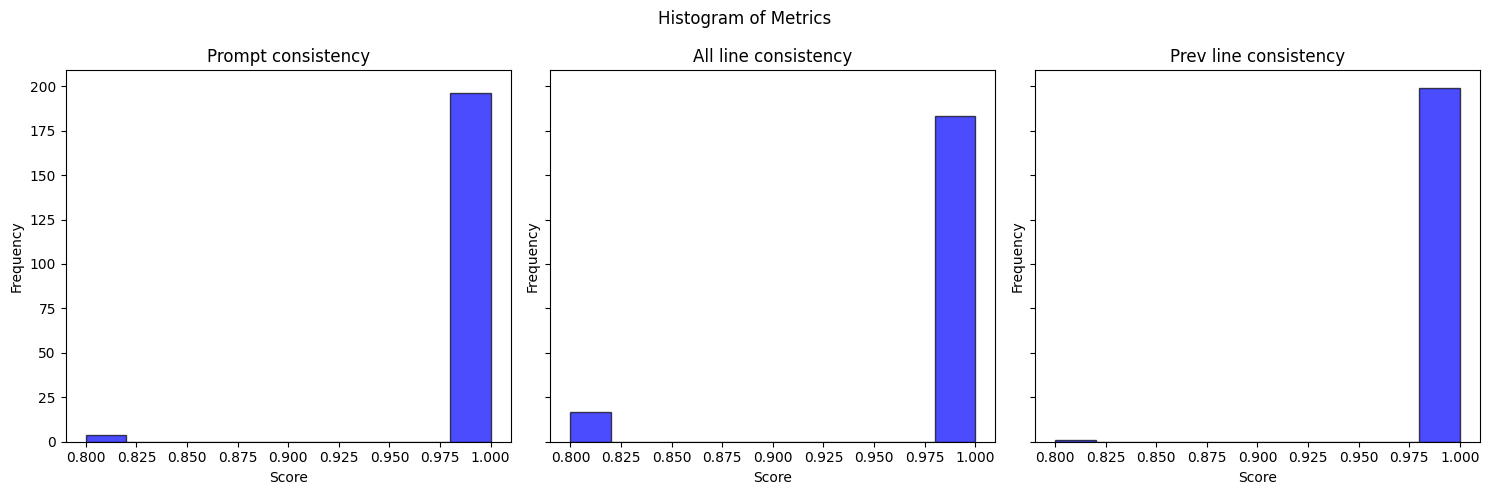

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# Extract metrics from conversations
metrics = {
    "prompt_consistency": [],
    "all_line_consistency": [],
    "prev_line_consistency": []
}

for conversation in conversations:
    metrics["prompt_consistency"].extend([
        conversation.get("P1_prompt_consistency_score", 0),
        conversation.get("P2_prompt_consistency_score", 0)
    ])
    metrics["all_line_consistency"].extend([
        conversation.get("P1_all_line_consistency_score", 0),
        conversation.get("P2_all_line_consistency_score", 0)
    ])
    metrics["prev_line_consistency"].extend([
        conversation.get("P1_prev_line_consistency_score", 0),
        conversation.get("P2_prev_line_consistency_score", 0)
    ])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Histogram of Metrics")

for ax, (metric, values) in zip(axes, metrics.items()):
    ax.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(metric.replace("_", " ").capitalize())
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from conversations
metrics = {
    "prompt_consistency": [],
    "all_line_consistency": [],
    "prev_line_consistency": []
}

for conversation in conversations:
    metrics["prompt_consistency"].extend([
        conversation.get("P1_prompt_consistency_score", 0),
        conversation.get("P2_prompt_consistency_score", 0)
    ])
    metrics["all_line_consistency"].extend([
        conversation.get("P1_all_line_consistency_score", 0),
        conversation.get("P2_all_line_consistency_score", 0)
    ])
    metrics["prev_line_consistency"].extend([
        conversation.get("P1_prev_line_consistency_score", 0),
        conversation.get("P2_prev_line_consistency_score", 0)
    ])

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Histogram of Metrics")

for ax, (metric, values) in zip(axes, metrics.items()):
    ax.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(metric.replace("_", " ").capitalize())
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [92]:
for conversation in conversations:
    eval_prompt_consistency(conversation, config_gpt4_mini)
conversations

[{'task_name': 'Persona Chat',
  'P1': ' i like to cook. i have lived in several different states. i worked as a nurse for many years. my husband was a salesman. i have a cat named kj.',
  'P2': ' i like fruit. my favorite fruit is apple. i don t like to eat meat. i like to eat the skin of the apple. i like green apples.',
  'conversation': ["P1: P1: Hey! What’s your favorite meal to cook? I love trying out new recipes, especially since I've lived in so many different states and picked up various culinary influences along the way.\n",
   "P2: I don't really cook meat, so I often make dishes that highlight fruits and vegetables. My favorite is a fresh apple salad with green apples, nuts, and a light dressing. It's simple, delicious, and lets the apple's flavor shine!\n",
   'P1: That sounds refreshing! I love incorporating seasonal fruits and veggies into my dishes too. Is there a specific time of year when you enjoy making your apple salad the most?\n',
   "P2: I love making my apple s

In [93]:
with open('data/persona/persona_chat2.json', 'w') as f:
        json.dump(conversations, f, indent=4)

In [107]:
for conversation in conversations:
    eval_all_line_consistency(conversation, config_gpt4_mini)
conversations

[{'task_name': 'Persona Chat',
  'P1': ' i like to cook. i have lived in several different states. i worked as a nurse for many years. my husband was a salesman. i have a cat named kj.',
  'P2': ' i like fruit. my favorite fruit is apple. i don t like to eat meat. i like to eat the skin of the apple. i like green apples.',
  'conversation': ["P1: P1: Hey! What’s your favorite meal to cook? I love trying out new recipes, especially since I've lived in so many different states and picked up various culinary influences along the way.\n",
   "P2: I don't really cook meat, so I often make dishes that highlight fruits and vegetables. My favorite is a fresh apple salad with green apples, nuts, and a light dressing. It's simple, delicious, and lets the apple's flavor shine!\n",
   'P1: That sounds refreshing! I love incorporating seasonal fruits and veggies into my dishes too. Is there a specific time of year when you enjoy making your apple salad the most?\n',
   "P2: I love making my apple s

In [111]:
for conversation in conversations:
    eval_prev_line_consistency(conversation, config_gpt4_mini)
conversations

[{'task_name': 'Persona Chat',
  'P1': ' i like to cook. i have lived in several different states. i worked as a nurse for many years. my husband was a salesman. i have a cat named kj.',
  'P2': ' i like fruit. my favorite fruit is apple. i don t like to eat meat. i like to eat the skin of the apple. i like green apples.',
  'conversation': ["P1: P1: Hey! What’s your favorite meal to cook? I love trying out new recipes, especially since I've lived in so many different states and picked up various culinary influences along the way.\n",
   "P2: I don't really cook meat, so I often make dishes that highlight fruits and vegetables. My favorite is a fresh apple salad with green apples, nuts, and a light dressing. It's simple, delicious, and lets the apple's flavor shine!\n",
   'P1: That sounds refreshing! I love incorporating seasonal fruits and veggies into my dishes too. Is there a specific time of year when you enjoy making your apple salad the most?\n',
   "P2: I love making my apple s

In [112]:
with open('data/persona/persona_chatf.json', 'w') as f:
        json.dump(conversations, f, indent=4)

In [ ]:
for conversation in orig_conversations:
    eval_prompt_consistency(conversation, config_gpt4_mini)
    eval_all_line_consistency(conversation, config_gpt4_mini)
    eval_prev_line_consistency(conversation, config_gpt4_mini)

with open('data/persona/syn_persona_chat.json', 'w') as f:
        json.dump(orig_conversations, f, indent=4)